In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [3]:
# Load the preprocessed dataset
df = pd.read_csv('processed_iot_sensor_data.csv', parse_dates=['timestamp'])

# Set timestamp as index
df.set_index('timestamp', inplace=True)

# Preview the data
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 431941 entries, 2024-12-01 00:59:00 to 2024-12-30 23:59:00
Data columns (total 48 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   temperature                   431941 non-null  float64
 1   vibration                     431941 non-null  float64
 2   pressure                      431941 non-null  float64
 3   humidity                      431941 non-null  float64
 4   failure                       431941 non-null  int64  
 5   machine_id                    431941 non-null  int64  
 6   temperature_lag_1             431941 non-null  float64
 7   temperature_lag_2             431941 non-null  float64
 8   temperature_lag_3             431941 non-null  float64
 9   vibration_lag_1               431941 non-null  float64
 10  vibration_lag_2               431941 non-null  float64
 11  vibration_lag_3               431941 non-null  float64
 12  pressure_l

In [4]:
# Select only the sensor columns for anomaly detection
sensor_columns = ['temperature', 'vibration', 'pressure', 'humidity']
X = df[sensor_columns]

# Normalize the data using MinMaxScaler (values between 0 and 1)
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

# Convert back to DataFrame for easy plotting
X_normalized = pd.DataFrame(X_normalized, columns=sensor_columns, index=df.index)

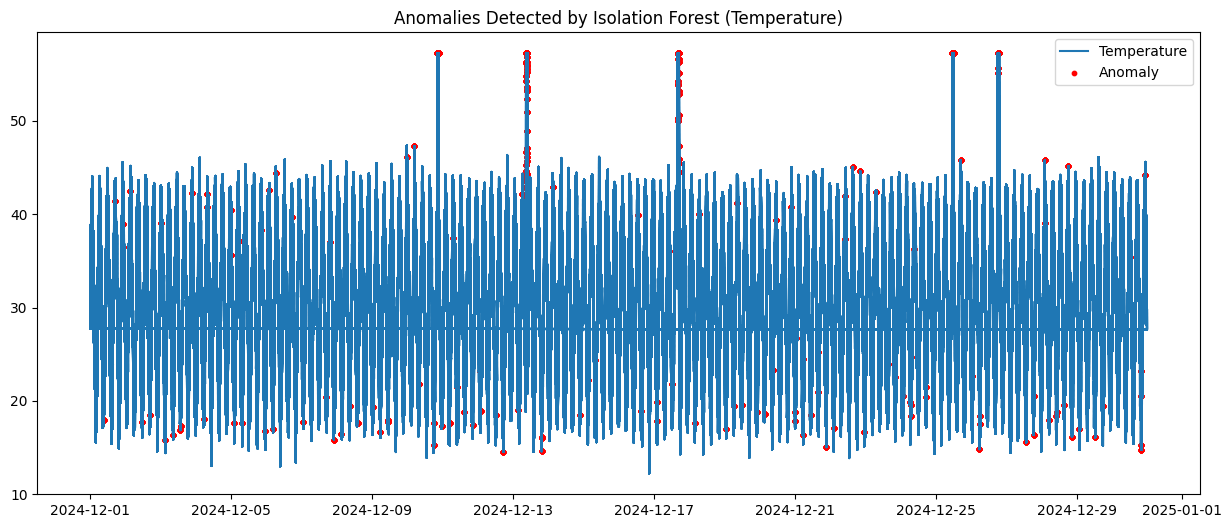

In [5]:
from sklearn.ensemble import IsolationForest

# Train Isolation Forest
isolation_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
df['anomaly_iforest'] = isolation_forest.fit_predict(X_normalized)

# Anomalies are marked as -1, normal points as 1
df['anomaly_iforest'] = df['anomaly_iforest'].apply(lambda x: 1 if x == -1 else 0)  # 1 for anomaly, 0 for normal

# Plot the anomalies
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['temperature'], label='Temperature')
plt.scatter(df[df['anomaly_iforest'] == 1].index, 
            df.loc[df['anomaly_iforest'] == 1, 'temperature'], 
            color='red', label='Anomaly', s=10)
plt.title('Anomalies Detected by Isolation Forest (Temperature)')
plt.legend()
plt.show()


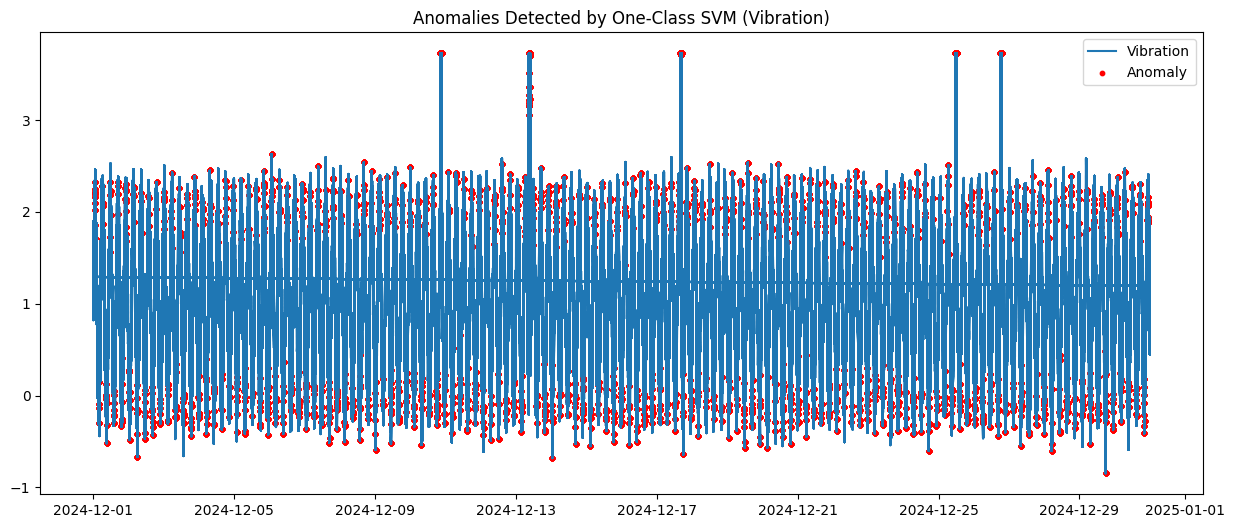

In [6]:
from sklearn.svm import OneClassSVM

# Train One-Class SVM
one_class_svm = OneClassSVM(kernel='rbf', gamma=0.01, nu=0.05)
df['anomaly_ocsvm'] = one_class_svm.fit_predict(X_normalized)

# Anomalies are marked as -1, normal points as 1
df['anomaly_ocsvm'] = df['anomaly_ocsvm'].apply(lambda x: 1 if x == -1 else 0)  # 1 for anomaly, 0 for normal

# Plot the anomalies
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['vibration'], label='Vibration')
plt.scatter(df[df['anomaly_ocsvm'] == 1].index, 
            df.loc[df['anomaly_ocsvm'] == 1, 'vibration'], 
            color='red', label='Anomaly', s=10)
plt.title('Anomalies Detected by One-Class SVM (Vibration)')
plt.legend()
plt.show()


In [7]:
# Define the Autoencoder model
input_dim = X_normalized.shape[1]

autoencoder = Sequential([
    Dense(16, activation='relu', input_shape=(input_dim,)),
    Dense(8, activation='relu'),
    Dense(16, activation='relu'),
    Dense(input_dim, activation='sigmoid')
])

autoencoder.compile(optimizer='adam', loss='mse')

# Train the Autoencoder
history = autoencoder.fit(X_normalized, X_normalized, 
                          epochs=20, 
                          batch_size=32, 
                          shuffle=True, 
                          validation_split=0.2, 
                          verbose=1)


C:\Users\sb075216\Desktop\Projects\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
10799/10799 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - loss: 0.0035 - val_loss: 8.7663e-05
Epoch 2/20
10799/10799 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 8.7475e-05 - val_loss: 8.3706e-05
Epoch 3/20
10799/10799 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 8.2284e-05 - val_loss: 8.0052e-05
Epoch 4/20
10799/10799 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 8.0610e-05 - val_loss: 8.1351e-05
Epoch 5/20
10799/10799 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 7.9243e-05 - val_loss: 7.5891e-05
Epoch 6/20
10799/10799 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 7.8126e-05 - val_loss: 7.5111e-05
Epoch 7/20
10799/10799 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 7.7426e-05 - val_loss: 7.7242e-05
Epoch 8/20
10799/10799 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 7.7643e-05 - val_loss: 7.1944e-05
Epoch 9/20
10799/10799 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 7.7006e-05 - val_loss: 7.2462e-05
Epoch 10/20
10799/10799 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 7.6786e-05 - val_loss: 8.2436e-05
Epoch 11/20
1

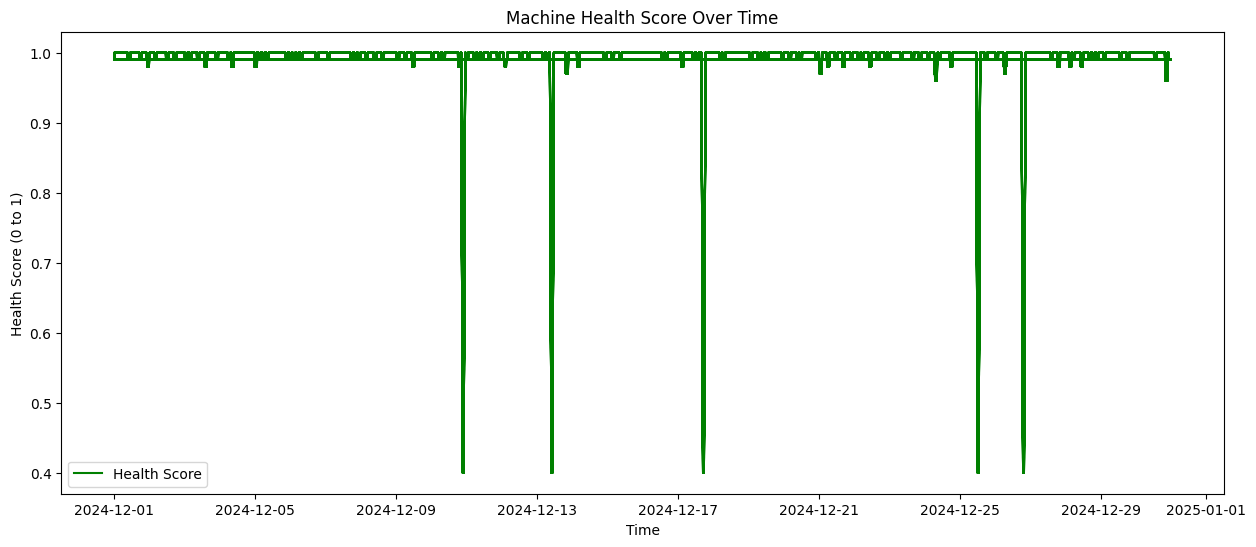

In [9]:
# Calculate health score (1 - % of anomalies in a sliding window)
window_size = 100  # Use a 100-sample sliding window
df['health_score'] = 1 - df['anomaly_iforest'].rolling(window_size).mean()

# Plot the health score over time
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['health_score'], label='Health Score', color='g')
plt.title('Machine Health Score Over Time')
plt.xlabel('Time')
plt.ylabel('Health Score (0 to 1)')
plt.legend()
plt.show()
